### Natural Language Processing with Disaster Tweets
This project will determent the semantic of a sentence by deep neural network


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from torch.utils.data import DataLoader
import transformers
import torch
import torch.nn as nn
from sklearn import model_selection, metrics
from tqdm import tqdm

### Data Inspection
let's look at our data before we do the processing 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.head(5))
print(test.head(5))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [3]:
n_classes = len(sorted(list(set(train['target']))))
print(train.info())
print(f'There are {n_classes} classes of target')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
There are 2 classes of target


In [4]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [5]:
for i in ['keyword', 'location']:
    print(f'{i} has {train[i].isna().sum()} NaN, {len(train[i].unique())} unique value')

keyword has 61 NaN, 222 unique value
location has 2533 NaN, 3342 unique value


0    4342
1    3271
Name: target, dtype: int64


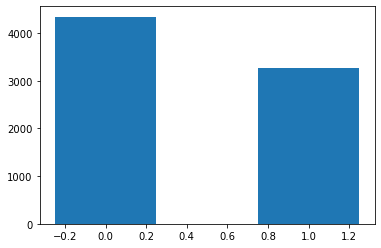

In [6]:
t = train['target'].value_counts()
plt.bar([0,1],t.values,width=0.5)
print(t)

Average words for training text is 13.928937344016813


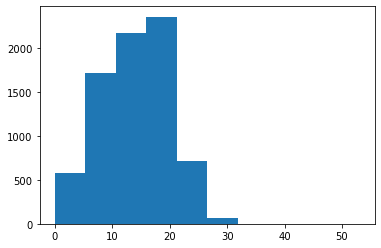

In [7]:
words_for_test = []
for i in train['text']:
    words_for_test.append(i.count(" "))
plt.hist(words_for_test)
print(f'Average words for training text is {np.average(words_for_test)}')

In [8]:
key_counts = train['keyword'].value_counts()
location_counts = train['location'].value_counts()

key_top_five = dict(sorted(key_counts.items(), key = lambda x: x[1], reverse = True)[:5])
location_top_five = dict(sorted(location_counts.items(), key = lambda x: x[1], reverse = True)[:5])
print(f'The top 5 keywords are {str(key_top_five)}')
print(f'The top 5 location are {str(location_top_five)}')

The top 5 keywords are {'fatalities': 45, 'deluge': 42, 'armageddon': 42, 'sinking': 41, 'damage': 41}
The top 5 location are {'USA': 104, 'New York': 71, 'United States': 50, 'London': 45, 'Canada': 29}


### Preprocessing
We will write a function for dataset, which will be using for training

In [9]:
class Dataset:
    def __init__(self, text, target, tokenizer, max_len):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item):
        text = " ".join(str(self.text[item]).split())
        inputs = tokenizer.encode_plus(text, None, add_special_tokens = True, max_length = self.max_len)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        
        padding_len = self.max_len - len(ids)
        ids = ids + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        
        return {
            "ids": torch.tensor(ids, dtype = torch.long),
            "mask": torch.tensor(mask, dtype = torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype = torch.long),
            "targets": torch.tensor(self.target[item], dtype = torch.float)
        }

### Setup model
Now, we will setup our model. Here, we will use transformer. Although we only learn LSTM and GUN, transformer is way better than traditional RNN, we will use the transformer library.

In [10]:
# This function will initialize the model
class BERTBaseUncased(nn.Module):
    def __init__(self, bert_path):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(bert_path)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)
        
    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(
            ids,
            attention_mask = mask,
            token_type_ids = token_type_ids, 
            return_dict = False
        )
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

Setup our hyperparameters

In [11]:
BERT_MODEL = "bert-base-uncased"
tokenizer = transformers.BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)
BATCH_SIZE = 8
MAX_LEN = 128
EPOCHS = 10

In [12]:
# we will drop other column beside the 'text'
train = train.drop(['keyword','location'], axis=1)
test = test.drop(['keyword','location'], axis=1)

Casting our dataset for bert dataset

In [13]:
train_data, valid_data = model_selection.train_test_split(train, test_size = 0.2, random_state = 4, stratify = train.target.values)

In [14]:
train_dataset = Dataset(text = train_data.text.values, target = train_data.target.values, tokenizer = tokenizer, max_len = MAX_LEN)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE)
valid_dataset = Dataset(text = valid_data.text.values, target = valid_data.target.values, tokenizer = tokenizer, max_len = MAX_LEN)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = BATCH_SIZE)

In [15]:
device = torch.device("cuda")
model = BERTBaseUncased(BERT_MODEL)
model.to(device)

BERTBaseUncased(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

### Evaluation
Because the project is a binary problem, we will use simple BCE as our evaluation loss. In this part we will evaluate different model and try the cross validation, we will find the best model for training.

In [16]:
def train_function(data_loader, model, optimizer, device, scheduler):
    model.train()
    for _, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"].to(device, dtype=torch.long)
        mask = d["mask"].to(device, dtype=torch.long)
        token_type_ids = d["token_type_ids"].to(device, dtype=torch.long)
        targets = d["targets"].to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [17]:
def eval_function(data_loader, model, device):
    model.eval()
    fin_outputs = []
    fin_targets = []
    with torch.no_grad():
        for _, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"].to(device, dtype=torch.long)
            mask = d["mask"].to(device, dtype=torch.long)
            token_type_ids = d["token_type_ids"].to(device, dtype=torch.long)
            targets = d["targets"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
    return np.vstack(fin_outputs), np.vstack(fin_targets)

In [18]:
def loss_function(predict, truth):
    return nn.BCEWithLogitsLoss()(predict, truth.view(-1, 1))

### Train and Test
After we get decide the model, we will train this model with all our training set, and predice the test input. We will get our final score on Kaggle.

In [19]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10)

In [20]:
model = nn.DataParallel(model)

In [23]:
best_accuracy = 0
for epoch in range(EPOCHS):
    train_function(train_loader, model, optimizer, device, scheduler)
    prediction, truth = eval_function(valid_loader, model, device)
    
    prediction = np.array(prediction) >= 0.5
    accuracy = metrics.accuracy_score(truth, prediction)
    print(f"Epoch {epoch}: Accuracy score = {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy

100%|██████████| 191/191 [00:09<00:00, 19.25it/s]


Accuracy score = 0.8115561391989494


100%|██████████| 191/191 [00:09<00:00, 19.70it/s]


Accuracy score = 0.7944845699277742


100%|██████████| 191/191 [00:09<00:00, 19.69it/s]


Accuracy score = 0.804333552199606


100%|██████████| 191/191 [00:13<00:00, 13.91it/s]


Accuracy score = 0.8056467498358503


100%|██████████| 191/191 [00:10<00:00, 18.75it/s]


Accuracy score = 0.7957977675640184


100%|██████████| 191/191 [00:10<00:00, 18.19it/s]


Accuracy score = 0.7380170715692712


100%|██████████| 191/191 [00:10<00:00, 17.89it/s]


Accuracy score = 0.7944845699277742


100%|██████████| 191/191 [00:10<00:00, 18.81it/s]


Accuracy score = 0.7905449770190414


100%|██████████| 191/191 [00:10<00:00, 18.56it/s]


Accuracy score = 0.7445830597504924


100%|██████████| 191/191 [00:10<00:00, 19.08it/s]

Accuracy score = 0.7787261982928431


### Prediction
Now, we will train the model with all the training data, and predict the test data

In [ ]:
train_all_data = Dataset(text = train.text.values, target = train.target.values, tokenizer = tokenizer, max_len = MAX_LEN)
train_loader = torch.utils.data.DataLoader(train_all_data, batch_size = BATCH_SIZE)

In [ ]:
device = torch.device("cuda")
model_final = BERTBaseUncased(BERT_MODEL)
model_final.to(device)
model = nn.DataParallel(model)

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10)

for epoch in range(EPOCHS):
    train_function(train_loader, model, optimizer, device, scheduler)

In [36]:
test['target'] = [0]*len(test)
test_data = Dataset(text = test.text.values, target = test.target.values, tokenizer = tokenizer, max_len = MAX_LEN)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1)

prediction, _ = eval_function(test_loader, model, device)


100%|██████████| 3263/3263 [00:41<00:00, 78.69it/s]


In [46]:
submission = pd.DataFrame()
submission['id'] = test['id']
prediction = np.array(prediction) >= 0.5
submission['target'] = prediction.astype(int)
print(submission.head())
submission.to_csv('submission.csv',index=False)

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


### Conclusion
This model have a not bad result, around 0.78 accuracy. We may improve the score by using a better model. Also, our training set is small, we can resample the training set.